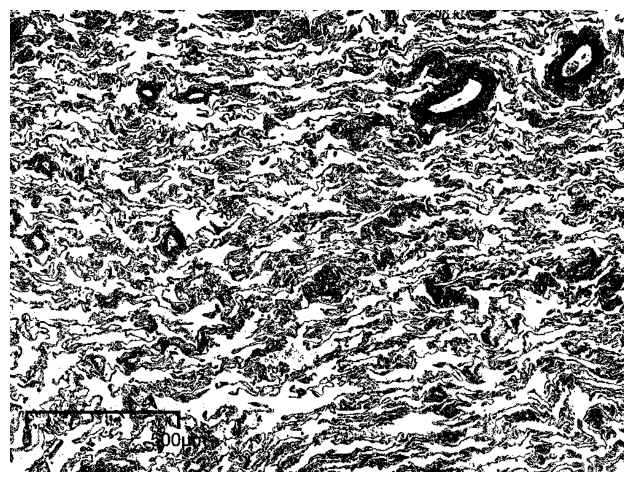

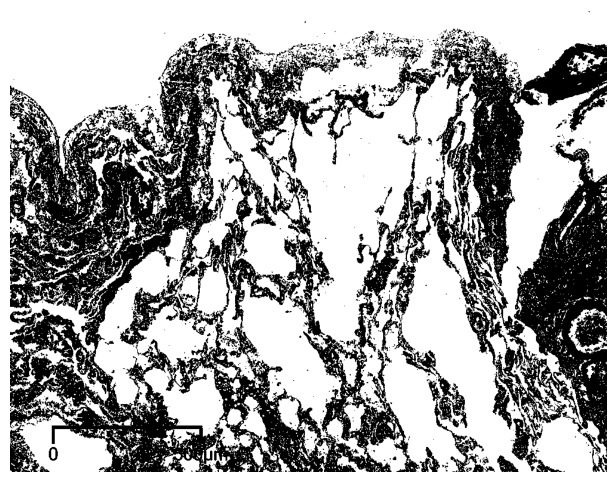

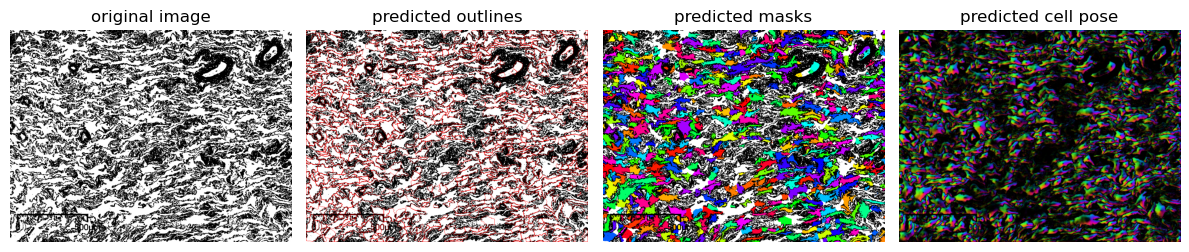

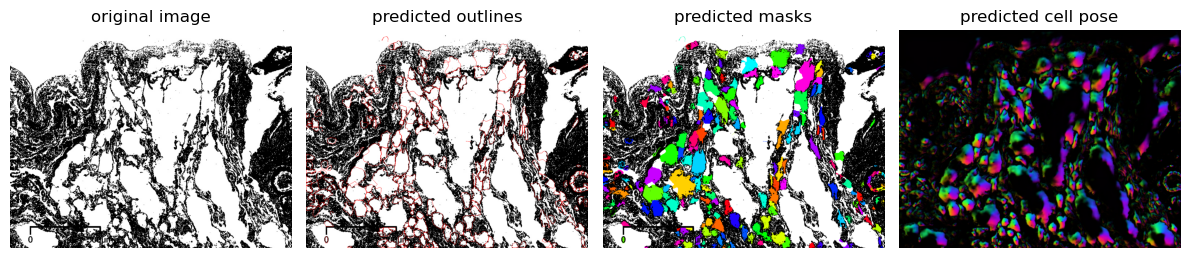

In [73]:
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob, os
from PIL import Image
from cellpose import plot
from cellpose import models
from cellpose.io import imread

# 定义函数

def Segmentation(files_ini,files_over,kern1,kern2):
    files_initial = glob.glob(files_ini)
    x=np.zeros(len(files_initial)) #图片长度
    y=np.zeros(len(files_initial)) #图片宽度
    px=np.zeros(len(files_initial)) #图片比例转换系数 1px→m
    for i in range(len(files_initial)):
        img = cv2.imread(files_initial[i],0)
        file_name = os.path.basename(files_initial[i])
        x[i]=len(img[0])
        y[i]=len(img)
        ret2, mask_OTSU = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel_size = kern1
        img = cv2.blur(mask_OTSU, kernel_size)
        ret2, mask_OTSU = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        #设置卷积核
        kernel = np.ones(kern2, np.uint8)
        dst = cv2.morphologyEx(mask_OTSU, cv2.MORPH_OPEN, kernel)
        
        #####################################
        #绘图
        plt.figure(figsize=(8, 6))
        plt.imshow(dst,cmap='gray')
        plt.axis("off")
        cv2.imwrite(files_over+file_name,dst)
        plt.show()
        #####################################
    return x,y,px

def size(sizes,files):
    size = sizes
    for infile in glob.glob(files):
        file, ext = os.path.splitext(infile)
        im = Image.open(infile)
        im.thumbnail(size)
        im.save(file + ".jpg", "JPEG")
        
def mask(file_over,files_mask,diam,flow,cellprob):
    file=file_over
    file2=files_mask
    model = models.CellposeModel(model_type='CP')
    files = glob.glob(file+"*.jpg")
    imgs = [imread(f) for f in files]
    masks, flows, styles = model.eval(imgs, diameter=diam, channels=[0,0],
                                      flow_threshold=flow, cellprob_threshold=cellprob,do_3D=False)#不同放大倍数需要调参
    for i in range(len(masks)):
        file_name = os.path.splitext(os.path.basename(files[i]))[0]
        cv2.imwrite(file2+file_name+".png",masks[i])
        
    #####################################
    #绘图
    nimg = len(imgs)
    channels = [[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]]
    for idx in range(nimg):
        maski = masks[idx]
        flowi = flows[idx][0]
        fig = plt.figure(figsize=(12,5))
        plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
        plt.tight_layout()
        plt.show()
    #####################################

# main
files_ini="pic_init/*.jpg"
files_over="pic_over/"
files_mask="pic_mask/"
## 图片裁剪
sizes=[1000,1000]
size(sizes,files_ini)
## 图片分割（不同放大倍数需要调参）
kern1=(1,1)
kern2=(1,1)
a=Segmentation(files_ini,files_over,kern1,kern2)
## 提取 mask（不同类型病理对应不同的 mask参数）
diam=20
flow=0.7
cellprob=-4
b=mask(files_over,files_mask,diam,flow,cellprob)

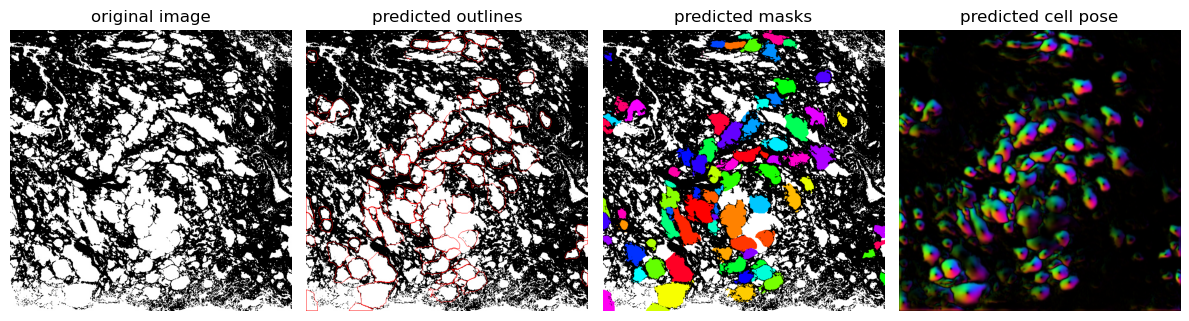

In [9]:
######测试用
from cellpose import models
from cellpose.io import imread

model = models.CellposeModel(model_type='CP')
files = ["pic_processed/3.jpg"]
imgs = [imread(f) for f in files]
masks, flows, styles = model.eval(imgs, diameter=50, channels=[0,0],
                                  flow_threshold=0.7,cellprob_threshold=-4,do_3D=False)
#画出来mask
from cellpose import plot
import matplotlib.pyplot as plt
nimg = len(imgs)
channels = [[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]]
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]
    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
    plt.tight_layout()
    plt.show()

In [ ]:
#imageJ运行deal.py生成参数表格

In [ ]:
from ij import IJ
import glob,os  
path="C:/Users/Yansong Han/Desktop/LungNew/pic_over"
i=0
for infile in glob.glob(path+"/*.png"):
    imp = IJ.openImage(infile)
    IJ.run(imp, "Analyze Regions", "area perimeter circularity max._feret")
    IJ.saveAs("Results", "C:/Users/Yansong Han/Desktop/LungNew/result/"+str(i)+".csv")
    i+=1

In [ ]:
import subprocess

#  Fiji 可执行文件的路径
fiji_executable_path = "C:\Users\Yansong Han\Desktop\Fiji.app\ImageJ-win64.exe"

#  Python 宏内容
python_macro = r"""
from ij import IJ
import glob,os  
path="C:\Users\Yansong Han\Desktop\参数提取自动化\pic_mask"
for infile in glob.glob(path+"/*.png"):
    file = os.path.splitext(os.path.basename(infile))[0]
    imp = IJ.openImage(infile)
    IJ.run(imp, "Analyze Regions", "area perimeter circularity max._feret")
    IJ.saveAs("Results", "C:\Users\Yansong Han\Desktop\参数提取自动化\data"+file+".csv")
"""

# 将 Python 宏写入一个临时文件
macro_file_path = '/macro.ijm'
with open(macro_file_path, 'w') as macro_file:
    macro_file.write(python_macro)

# 构建 Fiji 调用命令
command = [fiji_executable_path, '--headless', '--console', macro_file_path]

# 运行 Fiji 并执行 Python 宏
subprocess.call(command, shell=True)

In [84]:
#  Python 宏内容
python_macro = r'''
from ij import IJ
import glob,os  
path="C:\Users\Yansong Han\Desktop\参数提取自动化\pic_mask"
for infile in glob.glob(path+"/*.png"):
    file = os.path.splitext(os.path.basename(infile))[0]
    imp = IJ.openImage(infile)
    IJ.run(imp, "Analyze Regions", "area perimeter circularity max._feret")
    IJ.saveAs("Results", "C:\Users\Yansong Han\Desktop\参数提取自动化\data"+file+".csv")
'''

# 将 Python 宏写入一个临时文件
macro_file_path = "macro.py"
with open(macro_file_path, "w") as py_file:
    py_file.write(python_macro)

In [ ]:
#  Fiji 可执行文件的路径
fiji_executable_path = "C:\Users\Yansong Han\Desktop\Fiji.app\ImageJ-win64.exe"

# 构建 Fiji 调用命令
command = [fiji_executable_path, '--headless', '--console', macro_file_path]

# 运行 Fiji 并执行 Python 宏
subprocess.call(command, shell=True)

In [87]:
from ij import IJ
import glob,os  
path = r"C:\Users\Yansong Han\Desktop\参数提取自动化\pic_mask"
for infile in glob.glob(path+"/*.png"):
    file = os.path.splitext(os.path.basename(infile))[0]
    imp = IJ.openImage(infile)
    IJ.run(imp, "Analyze Regions", "area perimeter circularity max._feret")
    IJ.saveAs("Results", r"C:\Users\Yansong Han\Desktop\参数提取自动化\data"+file+".csv")

ModuleNotFoundError: No module named 'ut'